# UE AI for robotics: Practials on Evolutionary Algorithms


* Student1: Name: Islem Surname: KOBBI
* Student2: Name: / Surname: /


To facilitate the corrections, we kindly ask each student to send the project on their own.


## Introduction

In this practical you will have the opportunity to test different multi-objective evolutionary algorithms and observe how they behave. For this purpose, different functions are provided to trace the individuals generated at each generation or to compare the results between them. You will also test [Gym](https://www.gymlibrary.dev/) (in its new version provided by the [gymnasium package](https://pypi.org/project/Gymnasium/), an environment used in reinforcement learning to conduct standardized learning experiments on (virtual) robots.

To get a basic understanding of evolutionary algorithms you are required to complete this notebook and submit it on Moodle.

**You are asked to ensure the readability of your notebook**: limit the display to what is necessary and don't forget to remove displays that you may use during the development and debugging phase. The readability of your notebook will affect the evaluation of your work.

You will need the [DEAP library](https://deap.readthedocs.io/en/master/) and [Gymnasium](https://github.com/Farama-Foundation/Gymnasium). These libraries are easily installed with the `pip` command, as shown below:

In [29]:
!pip install deap
!pip install gymnasium

^C


Note: you can also use the [SCOOP](https://github.com/soravux/scoop) (Scalable COncurrent Operations in Python) library, which allows you to parallelize the execution of your experiments and thus make the execution much faster. However, SCOOP cannot be used directly in a jupyter notebook. If you want to use it, you have to put your code in a python file and run it with a `python -m scoop my_code.py`. You are advised to start with the notebook. You will be able to use small population sizes and few generations. If you finish early, you can use SCOOP to run experiments with more varied population sizes and more generations.

In [ ]:
# Note: the import of a file is done only once. If you modify this file,
# you have to restart your kernel if you want to take the changes into account.
# You can avoid this in the following way:
import importlib # one time only

#import my_module_python # the module must have been imported once
#importlib.reload(my_module_python) # this line allows to load the last version

import matplotlib.pyplot as plt
import numpy as np

# so that the figures appear directly in the notebook
%matplotlib inline

from deap import base, creator, benchmarks, algorithms

import random
from deap import tools

# do not forget to initialize the random seed
#The seed() method is used to initialize the random number generator.
#The random number generator needs a number to start with (a seed value), to be able to generate a random number.
random.seed(45)


## 1. Getting started with DEAP

In the rest of the practical, you will be asked to use [DEAP](https://deap.readthedocs.io/en/master/index.html), which is an open source python library.

DEAP is a library for rapid prototyping of evolutionary algorithms. It allows to work at several levels, from the complete implementation of the algorithm from basic bricks to the black-box use of a fully implemented algorithm and through intermediate approaches, in which modules are reused, for example for selection, mutations or crossovers.  


Write an elitist evolutionary algorithm that will generate lambda parameter vector individuals and choose the best `mu` from the parents and children.

You will use a SBX ([Simulated Binary Crossover](https://wpmedia.wolfram.com/uploads/sites/13/2018/02/09-2-2.pdf)) type crossover and a bounded polynomial type mutation (`eta=15.0`).

The parameters will be between `-5` and `5` (you can use `random.uniform` for the initialization).

You will use the functions of the DEAP toolbox to make your implementation easier and you will be able to draw inspiration from the examples provided.

You will test your algorithm on the [Ackley function](https://machinelearningmastery.com/differential-evolution-global-optimization-with-python/#:~:text=The%20Ackley%20function%20is%20an,%5D%2C%20which%20evaluates%20to%200.0.). It is available in DEAP and can be called in any dimension. You can do your tests with dimension `10`, for example.


Evolutionary algorithms have a stochastic part and therefore do not always give the same result. You will therefore plot the evolution of the average fitness for 10 independent runs. Instead of plotting the `10` curves, you will plot the median of the averages and an interval representing the 1st and 3rd quartile. You will do this as follows:

    plt.plot(gen,means, label="Median of the average fitnesses")
    plt.fill_between(gen, fit_25, fit_75, alpha=0.25, linewidth=0)

`gen` being a list of generations, `means` the list of medians of means and `fit_25` and `fit_75` the 1st and 3rd quartiles for these generations. You can determine `fit_25` and `fit_75` with the quantile function of numpy: `quantile(points, 0.25)` and `quantile(points, 0.75)`, with points a list that contains the fitness of the different runs at a given generation (so you have to loop and call these functions for each generation).


Draw the curves for populations of increasing size: [5, 10, 100, 200]. What do you notice?


In [ ]:
# parameters values
MIN_VALUE = -5
MAX_VALUE = 5
CXPB = 0.8 # Crossover rate
MUTPB = 0.2 # Mutation rate

In [47]:
# complete the code in this cell

def ea_simple(n, nbgen, evaluate, IND_SIZE, weights=(-1.0,)):
    """Elitist evolutionary algorithm

    Elitist evolutionary algorithm.
    :param n: population size
    :param nbgen: number of generations
    :param evaluate: the evaluation function
    :param IND_SIZE: the size of an individual
    :param weights: the weights to use for the fitness (here it will be (-1.0,) for a function to minimize and (1.0,) for a function to maximize)
    """

    if (hasattr(creator, "FitnessMin")):
        del creator.FitnessMin
    if (hasattr(creator, "Individual")):
        del creator.Individual

    creator.create("FitnessMin", base.Fitness, weights=weights)
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()

    #################################################
    #################################################

    # Register the necessary functions
    toolbox.register("attr_float", random.uniform, MIN_VALUE, MAX_VALUE)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=IND_SIZE)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", evaluate)

    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1) 
    toolbox.register("mate", tools.cxTwoPoint)                              
    toolbox.register("select", tools.selTournament, tournsize=3)            

    #################################################
    #################################################

    
    # Statistics to retrieve the results
    stats = tools.Statistics(key=lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # The structure that allows to store the statistics
    logbook = tools.Logbook()
    logbook.header = ["gen","min", "avg", "std", "max"]

    # The structure to recover the best individual
    hof = tools.HallOfFame(1)

    
    pop = toolbox.population(n=n) # initialize the population 
 
    for gen in range(1, nbgen):

        fitness_values = toolbox.map(toolbox.evaluate, pop) # calculate the coresponding fitnesses values 

        # associating eache individual with it's evaluation 
        for individual, fitness in zip(pop, fitness_values): 
            individual.fitness.values = [fitness]


        # update the hall of fame and the logbook 
        hof.update(pop)
        stat = stats.compile(pop)
        logbook.record(gen=gen,**stat)

        
        # Select the next generation
        offspring = toolbox.select(pop, n)

        # Apply crossover and mutation operators
        offspring = [toolbox.clone(ind) for ind in offspring]


        # making the crosover for CXPB*100 % of the time 
        if len(offspring) > 1 and len(offspring[0]) > 1:
    
            for child1, child2 in zip(offspring[::2], offspring[1::2]):

                if len(child1) > 1 and len(child2) > 1 and random.random() < CXPB:
                    toolbox.mate(child1, child2)

        # making the crosover for MUTPB*100 % of the time 
        for mutant in offspring:
            if random.random() < MUTPB :
                toolbox.mutate(mutant)

        # Replace the population with the offspring
        pop[:] = offspring

    # update the hall of fame and the logbook for the last time 
    hof.update(pop)
    stat = stats.compile(pop)
    logbook.record(gen=gen,**stat)
    
    return pop, hof, logbook


In [48]:
#the ackley function 
def ackley(individual):
    N = len(individual)
    term1 = -20.0 * np.exp(-0.2 * np.sqrt(sum(x**2 for x in individual) / N))
    term2 = -np.exp(sum(np.cos(2 * np.pi * x) for x in individual) / N)
    return term1 + term2 + 20.0 + np.exp(1)

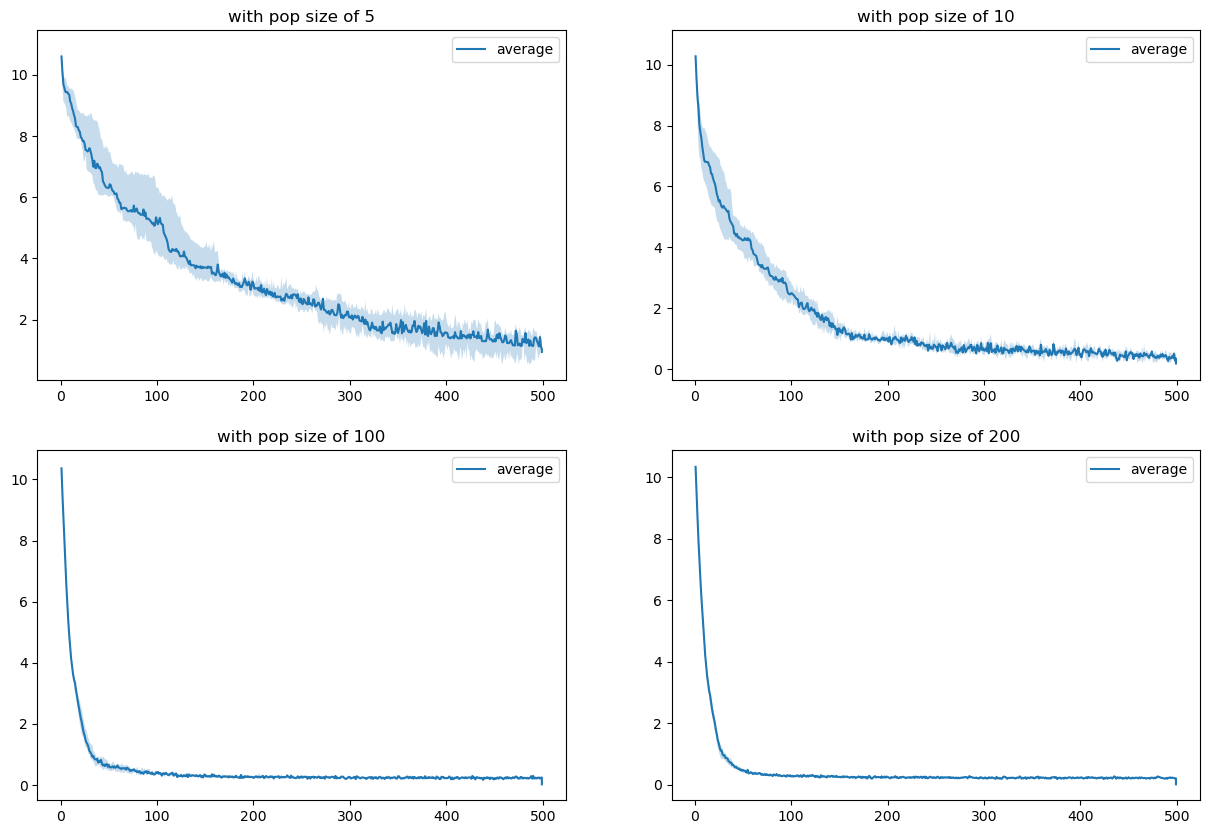

In [50]:
pop_size = [5, 10, 100, 200]
nbgen = 500 
ind_size = 10
nbrun = 10

plt.figure(figsize=[15,10])
for i in range(4) :

    all_avg=[[] for _ in range(nbgen)]

    for _ in range(nbrun):

        popi, hofi, logbooki=ea_simple(pop_size[i], nbgen, ackley, ind_size)
        geni, min_vi, avg_vi, max_vi=logbooki.select("gen", "min", "avg", "max")

        for j in range(nbgen):
            all_avg[j].append(avg_vi[j])



    plt.subplot(2,2,i+1)
    plt.title("with pop size of " + str(pop_size[i]))
    median_min=[np.median(all_avg[i]) for i in range(len(all_avg))]
    q25_min=[np.quantile(all_avg[i], 0.25) for i in range(len(all_avg))]
    q75_min=[np.quantile(all_avg[i], 0.75) for i in range(len(all_avg))]
    plt.plot(geni,median_min,label='average')
    plt.fill_between(geni, q25_min, q75_min, alpha=0.25, linewidth=0)
    plt.legend()


plt.show()


** Comments on the results**: The test consisted of conducting 10 independent runs, and the graphs presented here serve as a reliable representation of the algorithm's behavior. Initially, we observed that the algorithm successfully converged to a favorable set of parameters, resulting in an average value close to zero. Additionally, we noticed a clear impact of the population size: larger population sizes allowed the algorithm to achieve promising results in fewer generations.

## 2. Policy learning with gym

The objective of this question is to do to learn the first policies. You will use a very simple problem: the inverted pendulum. It consists in controlling a pendulum fixed on a cart and able to rotate. The cart can move horizontally with two actions (["bang-bang" control](https://en.wikipedia.org/wiki/Bang%E2%80%93bang_control)). The horizontal movements of the pendulum cause the pendulum to swing and the goal is to keep it vertical. You will use a neural network type policy. The corresponding code is provided in the appendix (so you have to run it to access the corresponding functions).

OpenAI-gym (now Gymnasium) is a framework for implementing reinforcement learning experiments. It offers a simple and unified interface and includes many environments used to test reinforcement learning algorithms. You will use this environment and its module [CartPole-v1](https://gymnasium.farama.org/environments/classic_control/cart_pole/).

Complete the code below. You will plot the results of the fitness as in the previous question. The calculations take more time, so do them according to your computational capacities and, if necessary, indicate in the comments what you would expect to observe with a higher computational power. You can do the plot only for one population size.

In [51]:
import gymnasium as gym

nn=SimpleNeuralControllerNumpy(4,1,2,5)
IND_SIZE=len(nn.get_parameters())
nn.init_random_params()
random_genotype = nn.get_parameters()

env = gym.make('CartPole-v1')
state, _ = env.reset()

"""
Comments:

the number of weights corresponds to the number of connections
the number of bias corresponds to the number of neurons
genotype is an array containing weights and biases

"""
def eval_nn(genotype, render=False, nbstep=500, nbrun=2):

    total_reward=0
    nn.set_parameters(genotype)

    for _ in range(nbrun) :
        
        state, _ = env.reset()
        
        for _ in range(nbstep):
            val = nn.predict(state)

            if val < 0 :
                action = 0
            else :
                action = 1

            next_state, reward, done, *_ = env.step(action)

            total_reward += reward  # Accumulate the total reward

            state = next_state

            if done :
                break
    

    return total_reward/nbrun


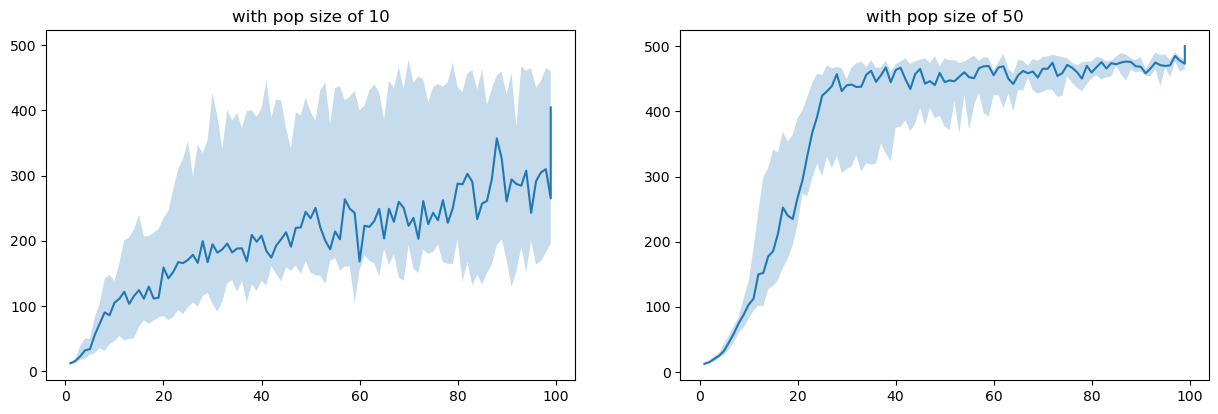

In [61]:
pop_size = [10, 50]
nbgen = 100
nbrun = 2

ind_size = len(random_genotype)  # 61

plt.figure(figsize=[15,10])
for i in range(2) :

    all_avg=[[] for _ in range(nbgen)]

    for _ in range(10):

        popi, hofi, logbooki = ea_simple(pop_size[i], nbgen, eval_nn, ind_size, weights=(1.0,))
        geni, min_vi, avg_vi, max_vi=logbooki.select("gen", "min", "avg", "max")

        for j in range(nbgen):
            all_avg[j].append(avg_vi[j])

    plt.subplot(2,2,i+1)
    median_min=[np.median(all_avg[i]) for i in range(len(all_avg))]
    q25_min=[np.quantile(all_avg[i], 0.25) for i in range(len(all_avg))]
    q75_min=[np.quantile(all_avg[i], 0.75) for i in range(len(all_avg))]
    plt.plot(geni,median_min, label="average reward")
    plt.fill_between(geni, q25_min, q75_min, alpha=0.25, linewidth=0)
    plt.title("with pop size of " + str(pop_size[i]))


plt.show()

** Comments on the results**: In this task, the objective is to maximize the reward, and we achieved this by setting the weights to 1. Similar to our previous findings, the algorithm successfully attained a commendable level of reward, approaching the maximum value of 500. Initially, the task posed challenges with a population size of 10. However, with an increase to 50, the algorithm reached its goal. This outcome underscores the potential for further improvements. With additional generations, a larger population, and increased computing resources, it is possible to discover even more optimal parameters. This would enable the reward to consistently remain at the maximum value of 500.

Note: The pendulum evaluation starts at a random position. Display the obtained fitness several times in a row by viewing the same individual. You should observe that the fitness obtained is not always the same. This is an illustration of the generalization problem: during learning, a policy has only been tested under a particular condition. If you change the conditions a bit, you have no guarantee of what will happen... To limit this problem, a simple strategy is to calculate the fitness not on a single evaluation, but on several. This should reduce the observed variability. If your computing power allows it, you can modify your evaluation function this way.

## 3 Implementing NSGA-II

Now implement NSGA-II based on the functions provided in DEAP. You will test NSGA-II on a multi-objective benchmark provided in DEAP, for example, the [Fonseca and Fleming function](http://www.mathlayer.com/support/benchmark-problems-fonseca-fleming.html).

It is not immediate to characterize the performance of a multi-objective algorithm with a one-dimensional indicator. You will use the hypervolume which corresponds to the volume bounded by the pareto front and a given reference point.

As before, plot the evolution of the hypervolume (median and 1st and 3rd quartiles) for populations of size [5, 10, 100, 200].

What do you notice?

In the case of the Fonseca function, you can use (1,1) as a reference point.

In [55]:
print("Example of use of the hypervolume calculation code. The hypothesis is that of a minimization.")
print("A reference point should be given corresponding to, for example, the maximum values for the objectives.")
from deap.tools._hypervolume import hv
print("Hypervolume: %f"%(hv.hypervolume([np.array([1,0]),np.array([0,1]),np.array([1,1])], np.array([2,2]))))


Example of use of the hypervolume calculation code. The hypothesis is that of a minimization.
A reference point should be given corresponding to, for example, the maximum values for the objectives.
Hypervolume: 3.000000


In [57]:
BOUND_LOW, BOUND_UP = -5, 5
CXPB = 0.9
MUTPB = 0.2

def my_nsga2(n, nbgen, evaluate, ref_point=np.array([1,1]), IND_SIZE=5, weights=(-1.0, -1.0)):
    """NSGA-2

    NSGA-2
    :param n: population size
    :param nbgen: number of generation
    :param evaluate: the evaluation function
    :param ref_point: the reference point for the calculation of the hypervolume
    :param IND_SIZE: the size of an individual
    :param weights: the weights to use for the fitness (here it will be (-1.0,) for a function to minimize and (1.0,) for a function to maximize)
    """

    """
    NSGA-2 Main Loop:

    1) Create offspring and a combined population
    2) Rank and sort offspring due to performance* on defined target indicators
    3) Take best members to create new population including a good spread in solutions

    * the performance here is given by the hypervolume
    """
    if (hasattr(creator, "MaFitness")):
        del creator.MaFitness
    if (hasattr(creator, "Individual")):
        del creator.Individual
    creator.create("MaFitness", base.Fitness, weights=weights)
    creator.create("Individual", list, fitness=creator.MaFitness)


    toolbox = base.Toolbox()
    paretofront = tools.ParetoFront()

    toolbox.register("attr_float", random.uniform, BOUND_LOW, BOUND_UP)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=IND_SIZE)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", evaluate)

    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1) 
    toolbox.register("mate", tools.cxTwoPoint)

    # Use binary tournament selection with crowding distance as a tie-breaker                            
    toolbox.register("select",  tools.selTournament, tournsize=3)    

    
    ## to complete (initialization, evaluation and update of the pareto front)
    pop = toolbox.population(n=n)

    
    for ind in pop:
        ind.fitness.values = toolbox.evaluate(ind)

    paretofront.update(pop) 

    
    pointset=[np.array(ind.fitness.getValues()) for ind in paretofront]
    s_hv=np.array([hv.hypervolume(pointset, ref_point)])


    # Begin the generational process
    for gen in range(1, nbgen):

        if (gen%10==0):
            print("+",end="", flush=True)
        else:
            print(".",end="", flush=True)

        # Apply crossover and mutation operators
        offspring = [toolbox.clone(ind) for ind in pop]

        # making the crosover for CXPB*100 % of the time 
        if len(offspring) > 1 and len(offspring[0]) > 1:
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if len(child1) > 1 and len(child2) > 1:
                    toolbox.mate(child1, child2)

        #making the crosover for MUTPB*100 % of the time 
        for mutant in offspring:
            toolbox.mutate(mutant)

        # Replace the population with the offspring
        pop[:] = offspring

        fitness_values = toolbox.map(toolbox.evaluate, pop) # calculate the coresponding fitnesses values 
        # associating eache individual with it's evaluation 
        for individual, fitness in zip(pop, fitness_values): 
            individual.fitness.values = fitness

        # Select the next generation
        pop = toolbox.select(pop, n)

        combined_pop = pop + list(paretofront) 
        
        for ind in combined_pop:
            ind.fitness.values = toolbox.evaluate(ind)

        paretofront.update(combined_pop) 

        # To recover the hypervolume, we will just put the different values in a vector s_hv which will be returned by the function.
        pointset=[np.array(ind.fitness.getValues()) for ind in paretofront]
        s_hv=np.append(s_hv, hv.hypervolume(pointset, ref_point))

    return pop, paretofront, s_hv

.........+.........+.........+.........+.........+.........+.........+.........+.........+..................+.........+.........+.........+.........+.........+.........+.........+.........+..................+.........+.........+.........+.........+.........+.........+.........+.........+..................+.........+.........+.........+.........+.........+.........+.........+.........+..................+.........+.........+.........+.........+.........+.........+.........+.........+..................+.........+.........+.........+.........+.........+.........+.........+.........+..................+.........+.........+.........+.........+.........+.........+.........+.........+..................+.........+.........+.........+.........+.........+.........+.........+.........+..................+.........+.........+.........+.........+.........+.........+.........+.........+..................+.........+.........+.........+.........+.........+.........+.........+.........+..................+

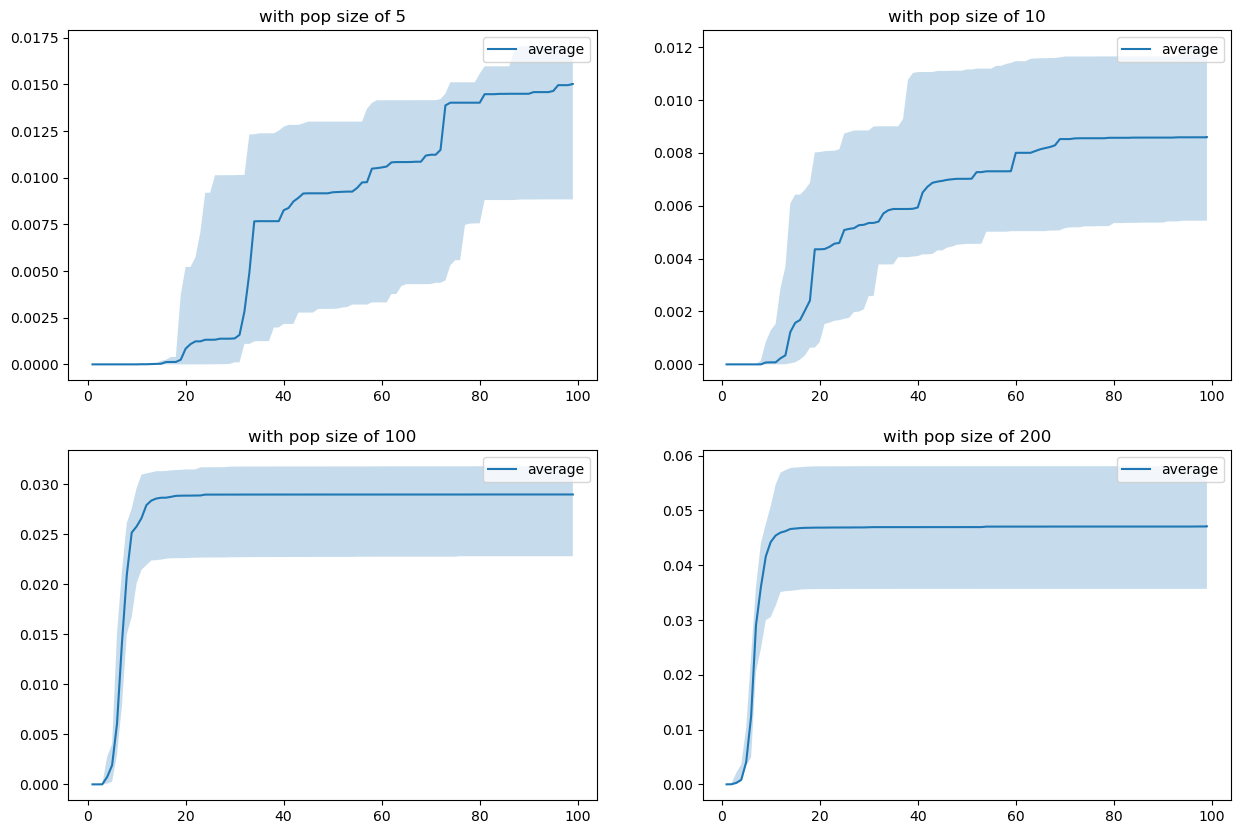

In [62]:
random.seed(45)
pop_size = [5, 10, 100, 200]
nbgenn = 100 # to reduce at first if too slow
nbrun = 10

def fonseca_fleming(x):
    sqrd = np.sqrt(3)
    term1 = 1 - np.exp(-np.sum((x - 1/sqrd)**2))
    term2 = 1 - np.exp(-np.sum((x + 1/sqrd)**2))
    return term1, term2


plt.figure(figsize=[15,10])

for i in range(4) :

    all_s_hv=[[] for _ in range(nbgen)]

    for _ in range(nbrun):

        pop, paretofront, s_hv = my_nsga2(pop_size[i], nbgenn, fonseca_fleming)

        for j in range(nbgen):
            all_s_hv[j].append(s_hv[j])


    plt.subplot(2,2,i+1)
    median_s_hv=[np.median(all_s_hv[i]) for i in range(len(all_s_hv))]
    q25_min=[np.quantile(all_s_hv[i], 0.25) for i in range(len(all_s_hv))]
    q75_min=[np.quantile(all_s_hv[i], 0.75) for i in range(len(all_s_hv))]
    plt.plot(geni,median_s_hv, label= 'average')
    plt.fill_between(geni, q25_min, q75_min, alpha=0.25, linewidth=0)
    plt.legend()
    plt.title("with pop size of " + str(pop_size[i]))

plt.show()

** Comments on the results**: The task involved finding optimal parameters to minimize both outputs of a multi-output function, with the evaluation criteria being the hypervolume relative to a reference point of (1, 1). In this context, the algorithm demonstrated strong performance, resulting in high hypervolume values. It was able to efficiently explore the parameter space and discover solutions that simultaneously minimized both outputs.

Similar to the single-objective case, the population size played a crucial role. Larger population sizes yielded better results and required fewer generations to reach satisfactory solutions. This highlights the effectiveness of a larger population in enhancing the algorithm's ability to find optimal parameter combinations for multi-objective optimization tasks.

## 4. Direct learning in the policy space, multi-objective version

The inverted pendulum is actually a multi-objective problem in which the pendulum must be kept vertical with the carriage centered in a given area.

Complete the code below to minimize the error in x and theta with NSGA-2. You will be able to plot the evolution of the hypervolume or modify the code of NSGA2 to plot the evolution of the error in x and the error in theta.


In [91]:
def eval_nn2(genotype, render = False, nbstep=200):
    """
    An observation gives us the following information:

    idx | info
    ------------------
    0	| Cart Position
    1	| Cart Velocity
    2	| Pole Angle
    3	| Pole Velocity At Tip

    """
    total_pos = 0 # the error in x is in observation[0]
    total_angle = 0 # the error in theta is in obervation [2]
    
    nn=SimpleNeuralControllerNumpy(4,1,2,5)
    nn.set_parameters(genotype)

    state, _ = env.reset(seed=42)


    total_pos, total_angle = [0,0]
    
    for _ in range(nbstep):

        
        val = nn.predict(state)

        if val < 0 :
            action = 0
        else :
            action = 1

        next_state, rewadr, done, *_ = env.step(action)

        total_pos += abs(state[0])
        total_angle += abs(state[2])
      
        state = next_state

        if done or abs(state[0]) > 4.8 or abs(state[2]) > 1.5 :
            total_pos = nbstep
            total_angle = nbstep
            break


    # ATTENTION: you are in the case of a fitness to minimize. Interrupting the evaluation
    # as soon as possible is a strategy that the evolutionary algorithm
    # algorithm can use to minimize the fitness. In the case where the pendulum falls before the end,
    # it is therefore necessary to add to the fitness a value that will guide the learning towards the right
    # behaviors. You can for example add n times a penalty, n being the number of time steps left. This will push the algorithm to minimize the penalty and thus avoid the fall. The penalty can be the error at the time of the fall or the maximum error.

    return total_pos/nbstep, total_angle/nbstep



.

........+.........+.........+.........+.........+.........+.........+.........+.........+..................+.........+.........+.........+.........+.........+.........+.........+.........+..................+.........+.........+.........+.........+.........+.........+.........+.........+..................+.........+.........+.........+.........+.........+.........+.........+.........+..................+.........+.........+.........+.........+.........+.........+.........+.........+..................+.........+.........+.........+.........+.........+.........+.........+.........+..................+.........+.........+.........+.........+.........+.........+.........+.........+..................+.........+.........+.........+.........+.........+.........+.........+.........+..................+.........+.........+.........+.........+.........+.........+.........+.........+..................+.........+.........+.........+.........+.........+.........+.........+.........+..................+.

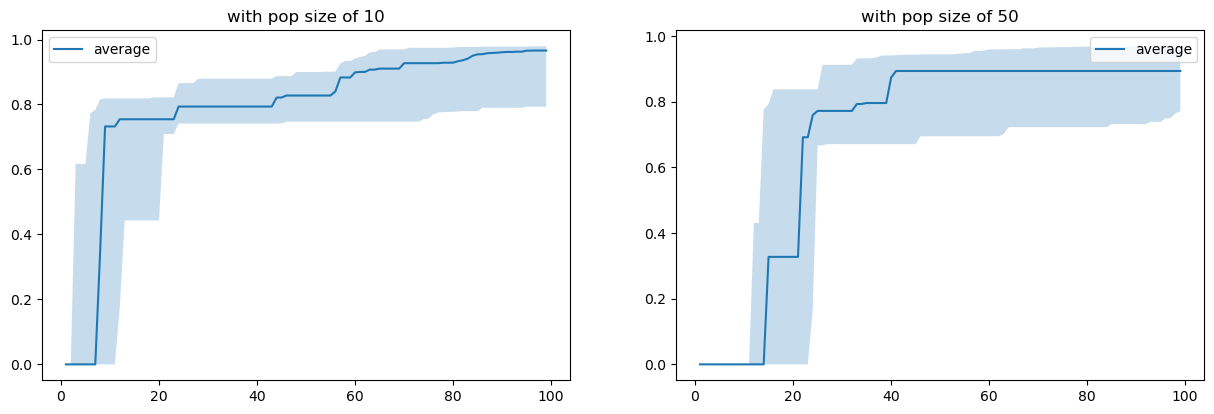

In [94]:
nn=SimpleNeuralControllerNumpy(4,1,2,5)
IND_SIZE=len(nn.get_parameters())

env = gym.make('CartPole-v1')

random.seed()
pop_size = [10, 50]
nbgenn = 100
nbrun = 10

plt.figure(figsize=[15,10])
for i in range(2) :

    all_s_hv=[[] for _ in range(nbgen)]

    for _ in range(nbrun):

        pop, paretofront, s_hv = my_nsga2(pop_size[1], nbgenn, eval_nn2, IND_SIZE=IND_SIZE,ref_point=[1,1])

        for j in range(nbgen):
            all_s_hv[j].append(s_hv[j])


    plt.subplot(2,2,i+1)
    median_s_hv=[np.median(all_s_hv[i]) for i in range(len(all_s_hv))]
    q25_min=[np.quantile(all_s_hv[i], 0.25) for i in range(len(all_s_hv))]
    q75_min=[np.quantile(all_s_hv[i], 0.75) for i in range(len(all_s_hv))]
    plt.plot(geni,median_s_hv, label= 'average')
    plt.fill_between(geni, q25_min, q75_min, alpha=0.25, linewidth=0)
    plt.legend()
    plt.title("with pop size of " + str(pop_size[i]))

plt.show()


** Comments on the results**: In this case, the task was to guide the car to position 0 while maintaining the pendulum in a vertical position. To achieve this, the algorithm aimed to find optimal parameters for the NN with the objectives of minimizing the total position error and the total angle error. To ensure faster performance and prevent divergence, the evaluation process was designed to stop if the system showed signs of divergence, returning the maximum error in such cases.

The output of the system was normalized to fall within the range of 0 to 1. This normalization allowed for the use of the point (1, 1) to compute the hypervolume.

In analyzing the results, it's evident that the algorithm successfully converged to an acceptable solution, as indicated by the high values of the hypervolume. Notably, experiments with a larger population size achieved the desired solution in fewer generations, demonstrating the advantages of a larger population in terms of computational efficiency and solution discovery.

Moreover, differences between runs with a high population size, especially in the later generations, were relatively lower. This suggests that a larger population size can lead to more consistent and reliable results in this optimization task.

# APPENDIX

In [ ]:

import os

def sigmoid(x):
    return 1./(1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)


def gen_simplemlp(n_in, n_out, n_hidden_layers=2, n_neurons_per_hidden=5):
    n_neurons = [n_neurons_per_hidden]*n_hidden_layers if np.isscalar(n_neurons_per_hidden) else n_neurons_per_hidden
    i = Input(shape=(n_in,))
    x = i
    for n in n_neurons:
        x = Dense(n, activation='sigmoid')(x)
    o = Dense(n_out, activation='tanh')(x)
    m = Model(inputs=i, outputs=o)
    return m


class SimpleNeuralControllerNumpy():
    def __init__(self, n_in, n_out, n_hidden_layers=2, n_neurons_per_hidden=5, params=None):
        self.dim_in = n_in
        self.dim_out = n_out
        # if params is provided, we look for the number of hidden layers and neuron per layer into that parameter (a dicttionary)
        if (not params==None):
            if ("n_hidden_layers" in params.keys()):
                n_hidden_layers=params["n_hidden_layers"]
            if ("n_neurons_per_hidden" in params.keys()):
                n_neurons_per_hidden=params["n_neurons_per_hidden"]
        self.n_per_hidden = n_neurons_per_hidden
        self.n_hidden_layers = n_hidden_layers
        self.weights = None
        self.n_weights = None
        self.init_random_params()
        self.out = np.zeros(n_out)
        #print("Creating a simple mlp with %d inputs, %d outputs, %d hidden layers and %d neurons per layer"%(n_in, n_out,n_hidden_layers, n_neurons_per_hidden))


    def init_random_params(self):
        if(self.n_hidden_layers > 0):
            self.weights = [np.random.random((self.dim_in,self.n_per_hidden))] # In -> first hidden
            self.bias = [np.random.random(self.n_per_hidden)] # In -> first hidden
            for i in range(self.n_hidden_layers-1): # Hidden -> hidden
                self.weights.append(np.random.random((self.n_per_hidden,self.n_per_hidden)))
                self.bias.append(np.random.random(self.n_per_hidden))
            self.weights.append(np.random.random((self.n_per_hidden,self.dim_out))) # -> last hidden -> out
            self.bias.append(np.random.random(self.dim_out))
        else:
            self.weights = [np.random.random((self.dim_in,self.dim_out))] # Single-layer perceptron
            self.bias = [np.random.random(self.dim_out)]
        self.n_weights = np.sum([np.product(w.shape) for w in self.weights]) + np.sum([np.product(b.shape) for b in self.bias])

    def get_parameters(self):
        """
        Returns all network parameters as a single array
        """
        flat_weights = np.hstack([arr.flatten() for arr in (self.weights+self.bias)])
        return flat_weights

    def set_parameters(self, flat_parameters):
        """
        Set all network parameters from a single array
        """
        i = 0 # index
        to_set = []
        self.weights = list()
        self.bias = list()
        if(self.n_hidden_layers > 0):
            # In -> first hidden
            w0 = np.array(flat_parameters[i:(i+self.dim_in*self.n_per_hidden)])
            self.weights.append(w0.reshape(self.dim_in,self.n_per_hidden))
            i += self.dim_in*self.n_per_hidden
            for l in range(self.n_hidden_layers-1): # Hidden -> hidden
                w = np.array(flat_parameters[i:(i+self.n_per_hidden*self.n_per_hidden)])
                self.weights.append(w.reshape((self.n_per_hidden,self.n_per_hidden)))
                i += self.n_per_hidden*self.n_per_hidden
            # -> last hidden -> out
            wN = np.array(flat_parameters[i:(i+self.n_per_hidden*self.dim_out)])
            self.weights.append(wN.reshape((self.n_per_hidden,self.dim_out)))
            i += self.n_per_hidden*self.dim_out
            # Samefor bias now
            # In -> first hidden
            b0 = np.array(flat_parameters[i:(i+self.n_per_hidden)])
            self.bias.append(b0)
            i += self.n_per_hidden
            for l in range(self.n_hidden_layers-1): # Hidden -> hidden
                b = np.array(flat_parameters[i:(i+self.n_per_hidden)])
                self.bias.append(b)
                i += self.n_per_hidden
            # -> last hidden -> out
            bN = np.array(flat_parameters[i:(i+self.dim_out)])
            self.bias.append(bN)
            i += self.dim_out
        else:
            n_w = self.dim_in*self.dim_out
            w = np.array(flat_parameters[:n_w])
            self.weights = [w.reshape((self.dim_in,self.dim_out))]
            self.bias = [np.array(flat_parameters[n_w:])]
        self.n_weights = np.sum([np.product(w.shape) for w in self.weights]) + np.sum([np.product(b.shape) for b in self.bias])

    def predict(self,x):
        """
        Propagage
        """
        if(self.n_hidden_layers > 0):
            #Input
            a = np.matmul(x,self.weights[0]) + self.bias[0]
            y = sigmoid(a)
            # hidden -> hidden
            for i in range(1,self.n_hidden_layers-1):
                a = np.matmul(y, self.weights[i]) + self.bias[i]
                y = sigmoid(a)
            # Out
            a = np.matmul(y, self.weights[-1]) + self.bias[-1]
            out = tanh(a)
            return out
        else: # Simple monolayer perceptron
            return tanh(np.matmul(x,self.weights[0]) + self.bias[0])

    def __call__(self,x):
        """Calling the controller calls predict"""
        return self.predict(x)
